# 8 - Predict slab flux

Predict the slab flux of subducting oceanic lithosphere using the thickness of the subducting plate calculated by plate models of lithospheric cooling (from [Grose, 2012](https://doi.org/10.1016/j.epsl.2012.03.037)), the convervenge velocity, and the trench segment length.

## Data packages

A plate reconstruction and corresponding age grids of the seafloor are required to predict slab dip. These may be downloaded from https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

The calculation has been tested on [Clennett _et al._ (2020)](https://doi.org/10.1029/2020GC009117) and [Müller _et al._ (2019)](https://doi.org/10.1029/2018TC005462) plate reconstructions but should also work fine for other plate reconstructions.


#### References

- Grose, C. J. (2012). Properties of oceanic lithosphere: Revised plate cooling model predictions. Earth and Planetary Science Letters, 333–334, 250–264. https://doi.org/10.1016/j.epsl.2012.03.037
- Clennett, E. J., Sigloch, K., Mihalynuk, M. G., Seton, M., Henderson, M. A., Hosseini, K., et al. (2020). A Quantitative Tomotectonic Plate Reconstruction of Western North America and the Eastern Pacific Basin. Geochemistry, Geophysics, Geosystems, 21(8), 1–25. https://doi.org/10.1029/2020GC009117
- Müller, R. D., Zahirovic, S., Williams, S. E., Cannon, J., Seton, M., Bower, D. J., et al. (2019). A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic. Tectonics, 38(6), 1884–1907. https://doi.org/10.1029/2018TC005462

In [1]:
%matplotlib inline
import gplately
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from plate_model_manager import PlateModelManager

Let's compare subduction zone data between two plate models: Müller et al. 2016 and Müller et al. 2019.

In [2]:
pm_manager = PlateModelManager()

muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")
rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
model = gplately.PlateReconstruction(rotation_model, topology_features)

muller2016_model = pm_manager.get_model("Muller2016", data_dir="plate-model-repo")
rotation_model2 = muller2016_model.get_rotation_model()
topology_features2 = muller2016_model.get_topologies()
model2 = gplately.PlateReconstruction(rotation_model2, topology_features2)

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

extent_globe = [-180,180,-90,90]

## Get kinematic data

We extract plate kinematic data for the present-day configuration of subduction zones to calculate the dip angle of subducting slabs.

In [3]:
def get_subduction_volume_rate(pmm_model, model, reconstruction_time):
        
    # calculate subduction convergence with gplately
    subduction_data = model.tessellate_subduction_zones(
        reconstruction_time, 
        output_subducting_absolute_velocity_components=True
    )

    subduction_lon     = subduction_data[:,0]
    subduction_lat     = subduction_data[:,1]
    subduction_angle   = subduction_data[:,3]
    subduction_norm    = subduction_data[:,7]
    subduction_pid_sub = subduction_data[:,8]
    subduction_pid_over= subduction_data[:,9]
    subduction_length  = np.radians(subduction_data[:,6])*gplately.tools.geocentric_radius(subduction_data[:,1])
    subduction_convergence = np.fabs(subduction_data[:,2])*1e-2 * np.cos(np.radians(subduction_data[:,3]))
    subduction_migration   = np.fabs(subduction_data[:,4])*1e-2 * np.cos(np.radians(subduction_data[:,5]))
    subduction_plate_vel = subduction_data[:,10]

    # remove entries that have "negative" subduction
    # this occurs when the subduction obliquity is greater than 90 degrees
    subduction_convergence = np.clip(subduction_convergence, 0, 1e99)

    # sample AgeGrid for current timestep

    # returns a Raster object
    graster = gplately.Raster(
        data=pmm_model.get_raster("AgeGrids", reconstruction_time),
        plate_reconstruction=model,
        extent=[-180, 180, -90, 90],
        )
    graster.fill_NaNs(inplace=True)
    age_interp = graster.interpolate(subduction_lon, subduction_lat)

    subduction_age = age_interp
    thickness = gplately.tools.plate_isotherm_depth(age_interp)

    # calculate subduction volume rate - m * m * m/yr
    subduction_vol_rate = thickness*subduction_length*subduction_convergence # integrated along subduction len
    subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr

    mean_plate_thickness             = thickness.mean()
    mean_subduction_segment_length   = subduction_length.sum()
    mean_subduction_convergence_rate = subduction_convergence.mean()
    total_subduction_volume_rate     = subduction_vol_rate.sum()
        
    return (mean_plate_thickness,
            mean_subduction_segment_length,
            mean_subduction_convergence_rate,
            total_subduction_volume_rate)

In [4]:
# Calculate the total subduction volume rate (km^3/yr) per timestep for each plate model
reconstruction_times = np.arange(0,231)

# Muller 2019 model
thk2019 = np.zeros(reconstruction_times.size) # mean plate thickness
len2019 = np.zeros(reconstruction_times.size) # subduction zone length
vel2019 = np.zeros(reconstruction_times.size) # mean convergence velocity
vol2019 = np.zeros(reconstruction_times.size) # subduction flux

# Muller 2016 model
thk2016 = np.zeros(reconstruction_times.size)
len2016 = np.zeros(reconstruction_times.size)
vel2016 = np.zeros(reconstruction_times.size)
vol2016 = np.zeros(reconstruction_times.size)


for t, time in enumerate(reconstruction_times):
    thk2019[t], len2019[t], vel2019[t], vol2019[t] = get_subduction_volume_rate(muller2019_model, model, time)
    thk2016[t], len2016[t], vel2016[t], vol2016[t] = get_subduction_volume_rate(muller2016_model, model2, time)

    gplately.tools.update_progress(time/reconstruction_times.size)    

Progress: [####################] 99.6%


### Parallel processing

GPlately supports parallel processing to distribute tasks over multiple processors. We recommend the [`joblib`](https://joblib.readthedocs.io/en/latest/) package to efficiently manage parallel resources. Below we demonstrate how the `get_subduction_volume_rate` function we defined above can be executed over multiple processors.

> Note: On Windows platforms it appears `joblib` is running slower in parallel than in serial. So we disable parallel processing (on Windows) with `n_jobs=None`.

In [5]:
from joblib import Parallel, delayed
import platform

# Use serial processing on Windows (runs slower in parallel than in serial for some reason). 
if platform.system() == 'Windows':
    n_jobs = None
else:
    n_jobs = -3  # use all CPUs except 2

# Use Loky Backend
parallel = Parallel(n_jobs=n_jobs, backend='loky', verbose=1)

reconstruction_times = np.arange(0, 231)

In [6]:
muller_2016_data = parallel(delayed(get_subduction_volume_rate)(muller2016_model, model2, time) for time in reconstruction_times)
muller_2019_data = parallel(delayed(get_subduction_volume_rate)(muller2019_model, model, time) for time in reconstruction_times)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  4.5min


In [7]:
# unpack numpy arrays
thk2016, len2016, vel2016, vol2016 = np.array(muller_2016_data).T
thk2019, len2019, vel2019, vol2019 = np.array(muller_2019_data).T

### Plot slab flux

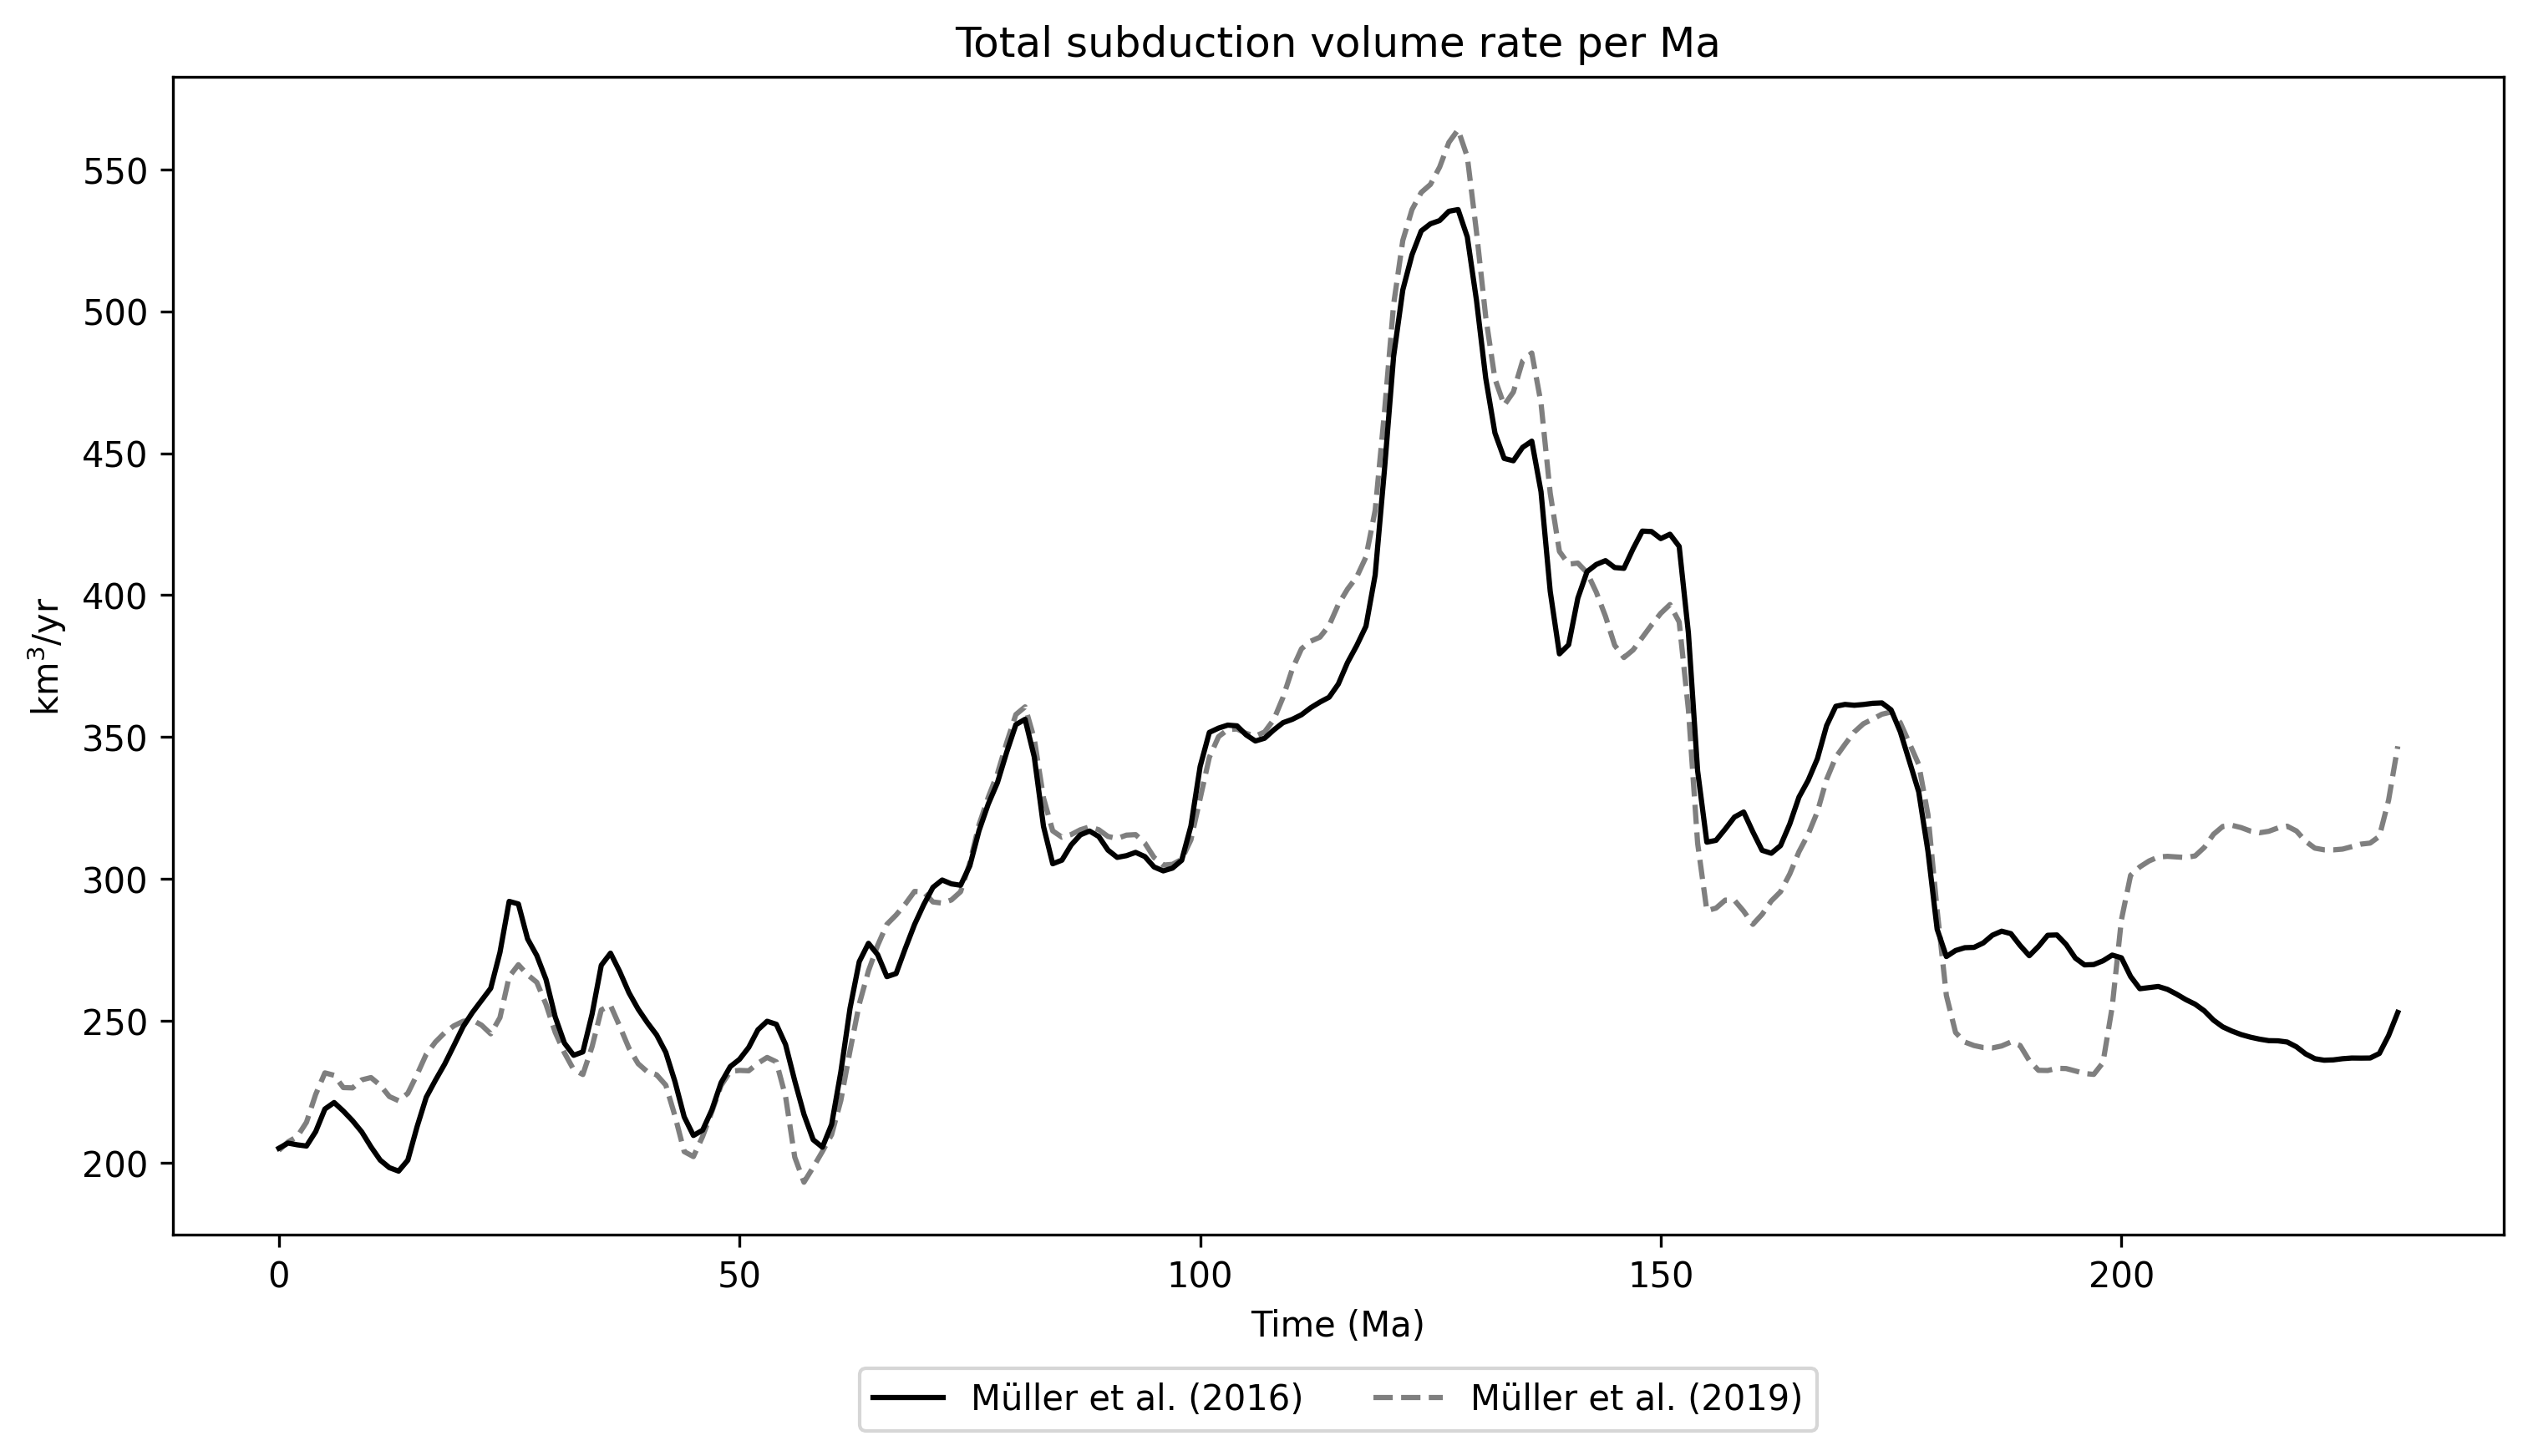

In [8]:
# Plot this data using a Gaussian filter
fig = plt.figure(figsize=(12,6), dpi=300)

muller2016_volumes_smoothed = gaussian_filter(vol2016, sigma=1)
muller2019_volumes_smoothed = gaussian_filter(vol2019, sigma=1)
plt.plot(reconstruction_times, muller2016_volumes_smoothed,
         color="k", label="Müller et al. (2016)")
plt.plot(reconstruction_times, muller2019_volumes_smoothed,
         linestyle="--", alpha=0.5, color="k", label="Müller et al. (2019)")
   
# Plot settings
plt.title("Total subduction volume rate per Ma")
plt.xlabel('Time (Ma)')
plt.ylabel('km$^3$/yr')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)